# Heat equation: analytic vs PINN

In [1]:
# 1D Heat equation PINN (PyTorch)
# PDE: u_t = alpha * u_xx, x in [0,1], t in [0,1]
# IC: u(x,0) = sin(pi x); BC: u(0,t)=u(1,t)=0

import math, torch, torch.nn as nn, torch.autograd as autograd
import matplotlib.pyplot as plt
from scipy.stats import qmc
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

alpha = 0.1


class MLP(nn.Module):
    def __init__(self, in_dim=2, out_dim=1, width=128, depth=4):
        super().__init__()
        layers = [nn.Linear(in_dim, width), nn.Tanh()]
        for _ in range(depth-1):
            layers += [nn.Linear(width, width), nn.Tanh()]
        layers += [nn.Linear(width, out_dim)]
        self.net = nn.Sequential(*layers)
        self.apply(self.init_xavier)

    @staticmethod
    def init_xavier(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight); nn.init.zeros_(m.bias)

    def forward(self, x, t):
        XT = torch.cat([x, t], dim=1)  # shape (N,2)
        return self.net(XT)

model = MLP().to(device)

In [2]:
N_f, N_i, N_b = 10000, 256, 256
# collocation points in interior

sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(n=N_f)

xf = torch.tensor(sample[:,0], dtype=torch.float32, device=device).unsqueeze(1)
tf = torch.tensor(sample[:,1], dtype=torch.float32, device=device).unsqueeze(1)

# initial line t=0
xi = torch.rand(N_i, 1, device=device)
ti = torch.zeros_like(xi, device=device)
ui_true = torch.sin(math.pi * xi)

# boundaries x=0 and x=1
tb = torch.rand(N_b, 1, device=device)
x0 = torch.zeros_like(tb, device=device)
x1 = torch.ones_like(tb, device=device)
ub0 = torch.zeros_like(tb, device=device)
ub1 = torch.zeros_like(tb, device=device)

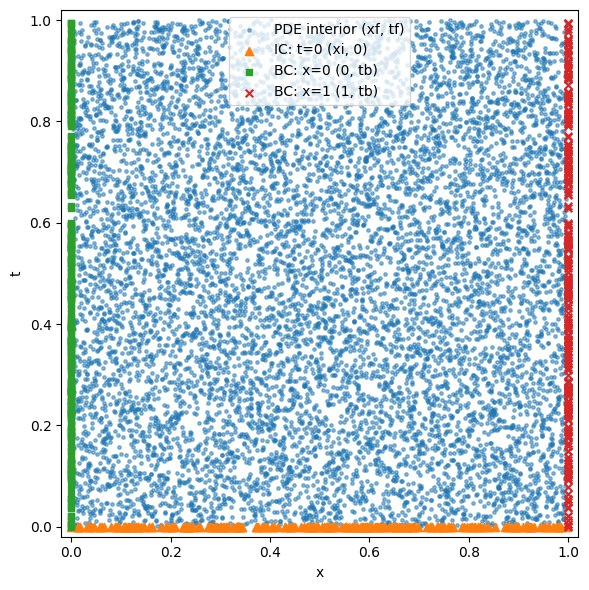

In [3]:
# Visualizing PINN sampling
# Domain: x in [0,1], t in [0,1]

plt.figure(figsize=(6,6))
plt.scatter(xf, tf, s=6, label="PDE interior (xf, tf)", alpha=0.5)
plt.scatter(xi, ti, marker="^", s=35, label="IC: t=0 (xi, 0)")
plt.scatter(x0, tb, marker="s", s=25, label="BC: x=0 (0, tb)")
plt.scatter(x1, tb, marker="x", s=30, label="BC: x=1 (1, tb)")
plt.xlabel("x")
plt.ylabel("t")
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
# autograd
def grad(outputs, inputs):
    return autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs),
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]

# PDE residual: r = u_t - alpha*u_xx
def pde_residual(x, t, alpha):
    x.requires_grad_(True)
    t.requires_grad_(True)

    u = model(x, t)
    u_t = grad(u, t)
    u_x = grad(u, x)
    u_xx = grad(u_x, x)

    # We return the residual r evaluated through autograd on the output node of the neural net (which is the approximated solution of the PDE)

    return u_t - alpha * u_xx

mse = nn.MSELoss()

def loss_fn():
    # In this function we collect all the losses: the residual loss (PDE) and the data (ICs and BCs).
    # The general idea is to constrain the neural net to find a solution that satisfies the PDE and the data.

    # PDE loss
    r = pde_residual(xf, tf, alpha)
    loss_pde = mse(r, torch.zeros_like(r))

    # Initial condition loss
    ui_pred = model(xi, ti)
    loss_ic = mse(ui_pred, ui_true)

    # Boundary conditions loss
    u0 = model(x0, tb)
    u1 = model(x1, tb)

    loss_bc = mse(u0, ub0) + mse(u1, ub1)

    # We return the total loss and the second part of the output is needed for later reporting

    return loss_pde + loss_ic + loss_bc, (loss_pde, loss_ic, loss_bc)

# train

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 10**3 * 3

for it in range(epochs):
    opt.zero_grad()
    L, (Lp, Li, Lb) = loss_fn()
    L.backward()
    opt.step()
    if it % 1000 == 0:
        print(f"it={it:4d}  total={L.item():.4e}  pde={Lp.item():.4e}  ic={Li.item():.4e}  bc={Lb.item():.4e}")

it=   0  total=4.2762e-01  pde=1.4235e-02  ic=2.8413e-01  bc=1.2926e-01
it=1000  total=1.5605e-02  pde=9.2523e-04  ic=3.5218e-03  bc=1.1158e-02
it=2000  total=1.7966e-04  pde=9.3218e-05  ic=3.2650e-05  bc=5.3793e-05


In [6]:
# Compare a trained PINN against the analytic 1D heat solution

alpha = 0.1

# Analytic solution: u_true(x,t) = exp(-alpha*pi^2*t) * sin(pi*x)
def u_true_np(x, t, alpha=alpha):
    return np.sin(np.pi * x) * np.exp(-alpha * np.pi**2 * t)

@torch.no_grad()
def pinn_u_grid(model, nx=201, nt=201):
    xs = torch.linspace(0, 1, nx, device=device).view(-1,1)
    ts = torch.linspace(0, 1, nt, device=device).view(-1,1)
    X, T = torch.meshgrid(xs.squeeze(), ts.squeeze(), indexing='ij')
    U_pred = model(X.reshape(-1,1), T.reshape(-1,1)).reshape(nx, nt)
    return X.cpu().numpy(), T.cpu().numpy(), U_pred.cpu().numpy()

# Model predictions on a grid
X, T, U_pred = pinn_u_grid(model, nx=201, nt=201)

# Analytical solution on the same grid
U_true = u_true_np(X, T, alpha=alpha)

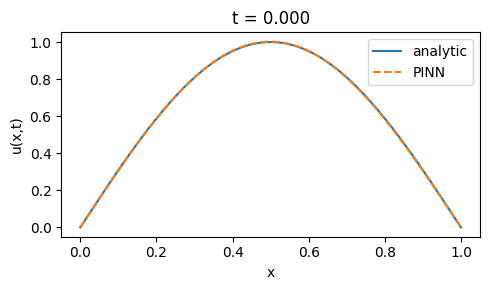

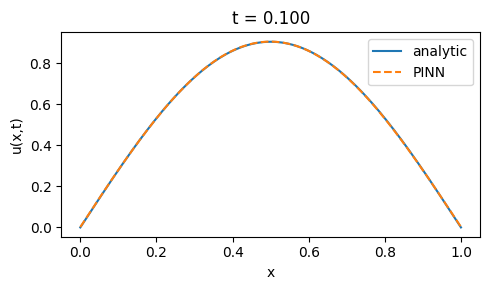

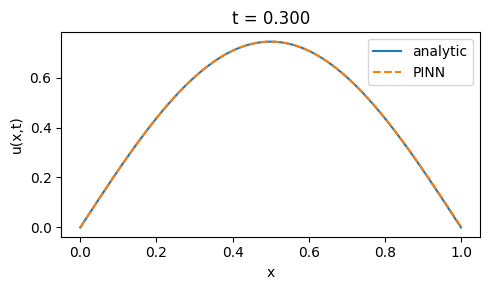

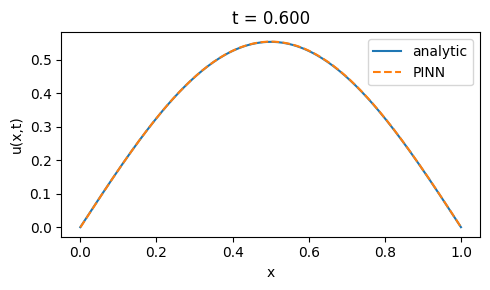

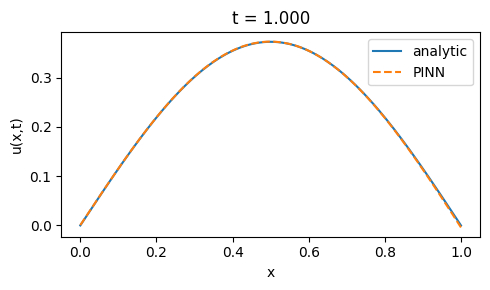

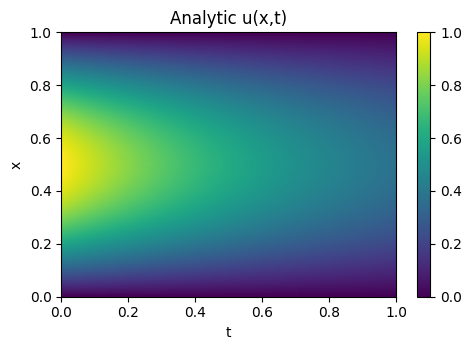

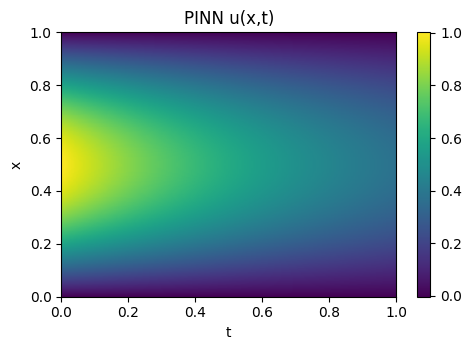

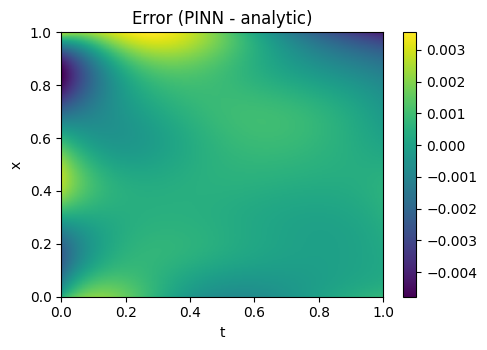

In [7]:
# Plots: a few time slices and 2D heatmaps

def slice_at_time(tval):
    j = np.argmin(np.abs(T[0,:] - tval))
    plt.figure(figsize=(5,3))
    plt.plot(X[:,j], U_true[:,j], label='analytic')
    plt.plot(X[:,j], U_pred[:,j], linestyle='--', label='PINN')
    plt.xlabel('x'); plt.ylabel('u(x,t)')
    plt.title(f't = {T[0,j]:.3f}')
    plt.legend(); plt.tight_layout(); plt.show()

for tval in (0.0, 0.1, 0.3, 0.6, 1.0):
    slice_at_time(tval)

plt.figure(figsize=(5,3.6))
plt.imshow(U_true, origin='lower', aspect='auto',
           extent=[T[0,0], T[0,-1], X[0,0], X[-1,0]])
plt.xlabel('t'); plt.ylabel('x'); plt.title('Analytic u(x,t)')
plt.colorbar(); plt.tight_layout(); plt.show()

plt.figure(figsize=(5,3.6))
plt.imshow(U_pred, origin='lower', aspect='auto',
           extent=[T[0,0], T[0,-1], X[0,0], X[-1,0]])
plt.xlabel('t'); plt.ylabel('x'); plt.title('PINN u(x,t)')
plt.colorbar(); plt.tight_layout(); plt.show()

plt.figure(figsize=(5,3.6))
plt.imshow(U_pred - U_true, origin='lower', aspect='auto',
           extent=[T[0,0], T[0,-1], X[0,0], X[-1,0]])
plt.xlabel('t'); plt.ylabel('x'); plt.title('Error (PINN - analytic)')
plt.colorbar(); plt.tight_layout(); plt.show()